In [2]:
# -------------------------------------------------------------
# YOLO Track — Block 1 : install + dataset prep (VOC → YOLO)
# -------------------------------------------------------------
!pip install -q ultralytics tqdm lxml

from pathlib import Path
import xml.etree.ElementTree as ET
import shutil, yaml, multiprocessing, os
from tqdm.auto import tqdm

root = Path("/content/data_yolo")          # where YOLO-formatted dataset will live
voc_root = Path("/content/VOC")            # raw VOC downloads

# -------------------------------------------------------------------
# 1. download Pascal-VOC 2007 & 2012 (train+val) with Ultralytics util
# -------------------------------------------------------------------
from ultralytics.utils.downloads import download

if not voc_root.exists():
    download(url='https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtrainval_06-Nov-2007.zip', dir=voc_root)
    download(url='https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtest_06-Nov-2007.zip',  dir=voc_root)
    download(url='https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtrainval_11-May-2012.zip', dir=voc_root)
    # unzip quietly
    !unzip -q -o "$voc_root/*2007*.zip" -d "$voc_root"
    !unzip -q -o "$voc_root/*2012*.zip" -d "$voc_root"

# class list (same 20 as before)
classes = [
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor",
]
cls2id = {c:i for i,c in enumerate(classes)}

# -------------------------------------------------------------------
# 2. convert VOC XML → YOLO TXT  (xmin,ymin,xmax,ymax → cx,cy,w,h  / normalized)
# -------------------------------------------------------------------
def voc_to_yolo(xml_path, txt_path, img_w, img_h):
    root_xml = ET.parse(xml_path).getroot()
    lines = []
    for obj in root_xml.iter("object"):
        cls = obj.find("name").text
        if cls not in cls2id: continue
        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = [float(bbox.find(t).text) for t in ('xmin','ymin','xmax','ymax')]
        # convert to YOLO (cx,cy,w,h) normalized 0-1
        cx = (xmin + xmax) / 2 / img_w
        cy = (ymin + ymax) / 2 / img_h
        w  = (xmax - xmin) / img_w
        h  = (ymax - ymin) / img_h
        lines.append(f"{cls2id[cls]} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")
    txt_path.write_text("\n".join(lines))

def process_split(split, year):
    img_dir  = voc_root/f"VOCdevkit/VOC{year}/JPEGImages"
    ann_dir  = voc_root/f"VOCdevkit/VOC{year}/Annotations"
    list_txt = voc_root/f"VOCdevkit/VOC{year}/ImageSets/Main/{split}.txt"

    dst_img = root/f"images/{split}"
    dst_lbl = root/f"labels/{split}"
    dst_img.mkdir(parents=True, exist_ok=True)
    dst_lbl.mkdir(parents=True, exist_ok=True)

    ids = list_txt.read_text().strip().split()
    for img_id in tqdm(ids, desc=f"VOC{year}-{split}"):
        src_img = img_dir/f"{img_id}.jpg"
        src_xml = ann_dir/f"{img_id}.xml"
        dst_img_file = dst_img/f"{img_id}.jpg"
        dst_lbl_file = dst_lbl/f"{img_id}.txt"

        # copy image
        if not dst_img_file.exists():
            shutil.copy2(src_img, dst_img_file)

        # parse size (needed for normalization)
        tree = ET.parse(src_xml).getroot()
        w = int(tree.find("size/width").text)
        h = int(tree.find("size/height").text)
        voc_to_yolo(src_xml, dst_lbl_file, w, h)

# build dataset (train = VOC07+12 trainval, val = VOC07 test)
process_split("trainval", "2007")
process_split("trainval", "2012")
process_split("test",     "2007")

# -------------------------------------------------------------------
# 3. create dataset YAML --------------------------------------------
yaml_path = root/"voc20.yaml"
yaml_dict = {
    'path': str(root),
    'train': 'images/trainval',
    'val'  : 'images/test',
    'nc'   : len(classes),
    'names': classes,
}
yaml_path.write_text(yaml.dump(yaml_dict))

print("\n✅ VOC converted → YOLO format")
print("Dataset root :", root)
print("YAML file    :", yaml_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo

100%|██████████| 425M/425M [00:10<00:00, 43.1MB/s]
Unzipping /content/VOC/VOCtrainval_06-Nov-2007.zip to /content/VOC/VOCdevkit...: 100%|██████████| 10945/10945 [00:04<00:00, 2317.26file/s]


100%|██████████| 418M/418M [00:11<00:00, 37.8MB/s]


WARNING ⚠️ Skipping /content/VOC/VOCtest_06-Nov-2007.zip unzip as destination directory /content/VOC/VOCdevkit is not empty.


100%|██████████| 1.82G/1.82G [00:53<00:00, 36.2MB/s]


WARNING ⚠️ Skipping /content/VOC/VOCtrainval_11-May-2012.zip unzip as destination directory /content/VOC/VOCdevkit is not empty.

2 archives were successfully processed.


VOC2007-trainval:   0%|          | 0/5011 [00:00<?, ?it/s]

VOC2012-trainval:   0%|          | 0/11540 [00:00<?, ?it/s]

VOC2007-test:   0%|          | 0/4952 [00:00<?, ?it/s]


✅ VOC converted → YOLO format
Dataset root : /content/data_yolo
YAML file    : /content/data_yolo/voc20.yaml


In [4]:
# -------------------------------------------------------------
# YOLO Track — 10-epoch quick-train on Pascal-VOC
# -------------------------------------------------------------
from ultralytics import YOLO

# 1️⃣  load COCO-pretrained YOLOv8-medium
model = YOLO("yolov8m.pt")               # good speed/accuracy trade-off

# 2️⃣  launch a 10-epoch fine-tune
model.train(
    data       = "/content/data_yolo/voc20.yaml",  # dataset YAML from Block 1
    epochs     = 10,
    imgsz      = 640,          # keep default input size
    batch      = 16,           # fits in T4 VRAM; raise if you have headroom
    lr0        = 0.02,         # slightly higher LR for fast convergence
    warmup_epochs = 1,
    optimizer  = "SGD",
    amp        = True,         # mixed precision
    pretrained = True,         # keep COCO weights as starting point
    name       = "voc_yolo_10e",
    project    = "/content/runs/detect",
    workers    = 8,
)


100%|██████████| 49.7M/49.7M [00:00<00:00, 300MB/s]


Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_yolo/voc20.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.02, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=voc_yolo_10e, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

train: Scanning /content/data_yolo/labels/trainval.cache... 16551 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16551/16551 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 739.6±383.2 MB/s, size: 90.6 KB)


val: Scanning /content/data_yolo/labels/test.cache... 4952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4952/4952 [00:00<?, ?it/s]


Plotting labels to /content/runs/detect/voc_yolo_10e/labels.jpg... 
optimizer: SGD(lr=0.02, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/runs/detect/voc_yolo_10e
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      9.35G      1.211      1.968      1.472         24        640: 100%|██████████| 1035/1035 [09:08<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [01:00<00:00,  2.57it/s]


                   all       4952      14976      0.171      0.133     0.0604     0.0272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      7.41G      1.697      2.758      1.942         14        640: 100%|██████████| 1035/1035 [09:00<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [01:00<00:00,  2.58it/s]


                   all       4952      14976      0.311       0.28       0.22      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      7.26G       1.49      2.306      1.766         30        640: 100%|██████████| 1035/1035 [08:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [00:57<00:00,  2.71it/s]


                   all       4952      14976      0.426      0.371      0.339      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      7.37G      1.366      2.002      1.655         13        640: 100%|██████████| 1035/1035 [08:58<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [00:57<00:00,  2.71it/s]


                   all       4952      14976      0.484      0.425      0.416      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      7.34G      1.275      1.801      1.584         17        640: 100%|██████████| 1035/1035 [08:58<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [00:56<00:00,  2.74it/s]


                   all       4952      14976       0.61      0.466      0.512      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      7.37G      1.195      1.619      1.511         14        640: 100%|██████████| 1035/1035 [08:58<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [00:57<00:00,  2.71it/s]


                   all       4952      14976      0.616      0.503      0.555       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      7.25G      1.128      1.463       1.45         26        640: 100%|██████████| 1035/1035 [08:58<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [00:56<00:00,  2.74it/s]


                   all       4952      14976      0.646      0.548      0.601      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      7.35G      1.068      1.336      1.397         21        640: 100%|██████████| 1035/1035 [08:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [00:57<00:00,  2.71it/s]


                   all       4952      14976      0.693       0.58       0.65      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      7.34G      1.015      1.216      1.355         11        640: 100%|██████████| 1035/1035 [08:59<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [00:56<00:00,  2.74it/s]


                   all       4952      14976      0.725      0.595      0.677      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      7.34G      0.964      1.111      1.311         19        640: 100%|██████████| 1035/1035 [08:58<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [00:56<00:00,  2.77it/s]


                   all       4952      14976      0.731      0.629      0.707      0.508

10 epochs completed in 1.665 hours.
Optimizer stripped from /content/runs/detect/voc_yolo_10e/weights/last.pt, 52.0MB
Optimizer stripped from /content/runs/detect/voc_yolo_10e/weights/best.pt, 52.0MB

Validating /content/runs/detect/voc_yolo_10e/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,851,340 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 155/155 [00:58<00:00,  2.63it/s]


                   all       4952      14976      0.731      0.629      0.707      0.508
             aeroplane        205        311      0.842      0.701      0.808      0.599
               bicycle        250        389      0.797      0.686      0.768      0.569
                  bird        289        576      0.724      0.564      0.661      0.428
                  boat        176        393      0.698      0.481      0.572      0.349
                bottle        240        657      0.746      0.499      0.587      0.382
                   bus        183        254      0.698      0.713      0.755      0.632
                   car        775       1541      0.806      0.772      0.841      0.635
                   cat        332        370      0.783        0.7      0.804      0.646
                 chair        545       1374      0.713      0.458      0.565      0.368
                   cow        127        329      0.678      0.608       0.68      0.461
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f94513eae50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

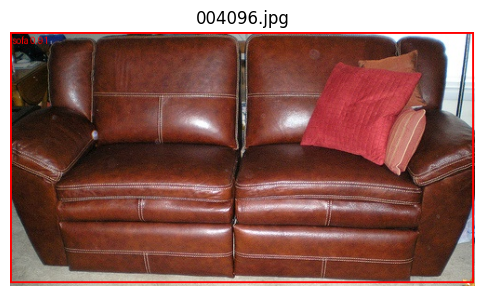

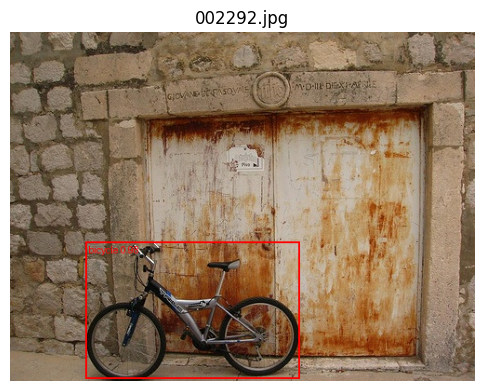

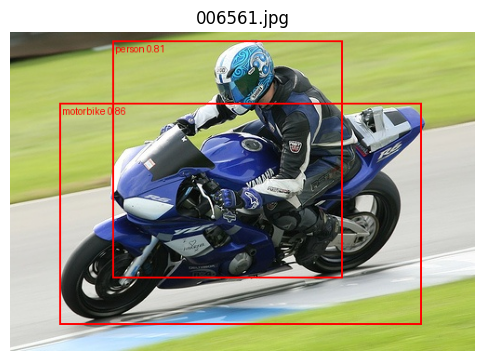

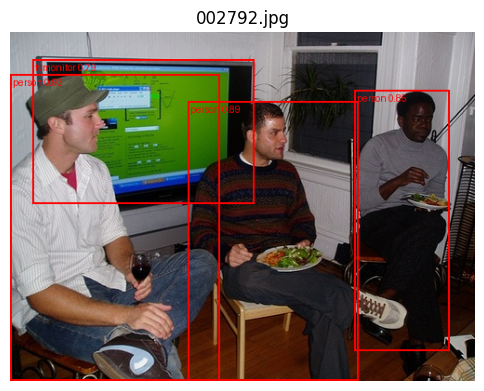

In [7]:
# -------------------------------------------------------------
# Block 3 : inference demo  —  visualise a few predictions
#            (for the 10-epoch YOLOv8-m model)
# -------------------------------------------------------------
from ultralytics import YOLO
import random, matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision.utils import draw_bounding_boxes
import torch

# 1️⃣  load best checkpoint
best_ckpt = "/content/runs/detect/voc_yolo_10e/weights/best.pt"
yolo = YOLO(best_ckpt)          # automatically loads to GPU if available
classes = [
    "aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa",
    "train","tvmonitor",
]

# 2️⃣  helper to draw predictions on an image tensor -------------------
def draw_preds(img_path, conf_thresh=0.35):
    im = Image.open(img_path).convert("RGB")
    np_img = np.array(im)
    results = yolo.predict(source=np_img, conf=conf_thresh, verbose=False)[0]

    boxes   = results.boxes.xyxy.cpu()
    scores  = results.boxes.conf.cpu()
    labels  = results.boxes.cls.cpu().long()

    label_strs = [f"{classes[l]} {s:.2f}" for l, s in zip(labels, scores)]
    drawn = draw_bounding_boxes(
        torch.from_numpy(np_img).permute(2,0,1),  # to C,H,W tensor
        boxes,
        labels=label_strs,
        colors="red",
        width=2,
        font_size=12,
    ).permute(1,2,0).numpy()

    plt.figure(figsize=(6,6))
    plt.imshow(drawn)
    plt.axis("off")

# 3️⃣  sample a few validation images (VOC07 test set) -----------------
val_img_dir = Path("/content/data_yolo/images/test")
samples = random.sample(list(val_img_dir.iterdir()), 4)

for p in samples:
    draw_preds(p)
    plt.title(p.name)
    plt.show()
